# Load packages

In [2]:
from core.DataLoader import *
from core.models.MLP import * 
from core.Visualizer import *
from core.models.Classifier import *

In [25]:
model_accs = {
    'MLP': [],
    'RF(5)': [],
    'RF(10)': [],
    'RF(U)': [],
    'DT(5)': [],
    'DT(10)': [],
    'DT(U)': [],
    'LR': [],
    'SVM': [],
    'XGB': []
}

In [26]:
weighted_clf_model_list ={
    "MLP": MLPClassifier,
    "DT": m_DecisionTreeClassifier,
    "RF": m_RandomForestClassifier,
    "LR": m_LogisticRegression,
    "SVM": SVMClassifier,
    "XGB": XGBOOSTClassifier
}
weighted_clf_model_name_list = ['MLP']

# Load data

In [27]:
engine = 'postgres'
dl = DataLoader(engine)
one_file_dss, one_file_names = dl.get_one_file_ds(return_type='ds and names', datasets=['ssb', 'imdb'])

In [28]:
key_features = [['sel_of_pred_on_indexed_attr', 'left_cardinality'], 
                ['sel_of_pred_on_indexed_attr_and_join_pred', 'left_cardinality'],
               ['sel_of_pred_on_indexed_attr_and_join_pred', 'sel_of_pred_on_indexed_attr_and_non_indexed_attr'],
               ['sel_of_pred_on_indexed_attr_and_join_pred', 'result_size']]

classification_target = dl.classification_target

key_feature_set = 0
features = key_features[key_feature_set]
print("Using features: ", features)

Using features:  ['sel_of_pred_on_indexed_attr', 'left_cardinality']


# Train model without sample weights

100%|██████████| 200/200 [00:21<00:00,  9.15it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Misprediction Costs: 
min: 0.40999999991618097; max: 3764.670000000042; median:1087.7999999999993; avg: 1180.0440740740773


<Figure size 432x288 with 0 Axes>

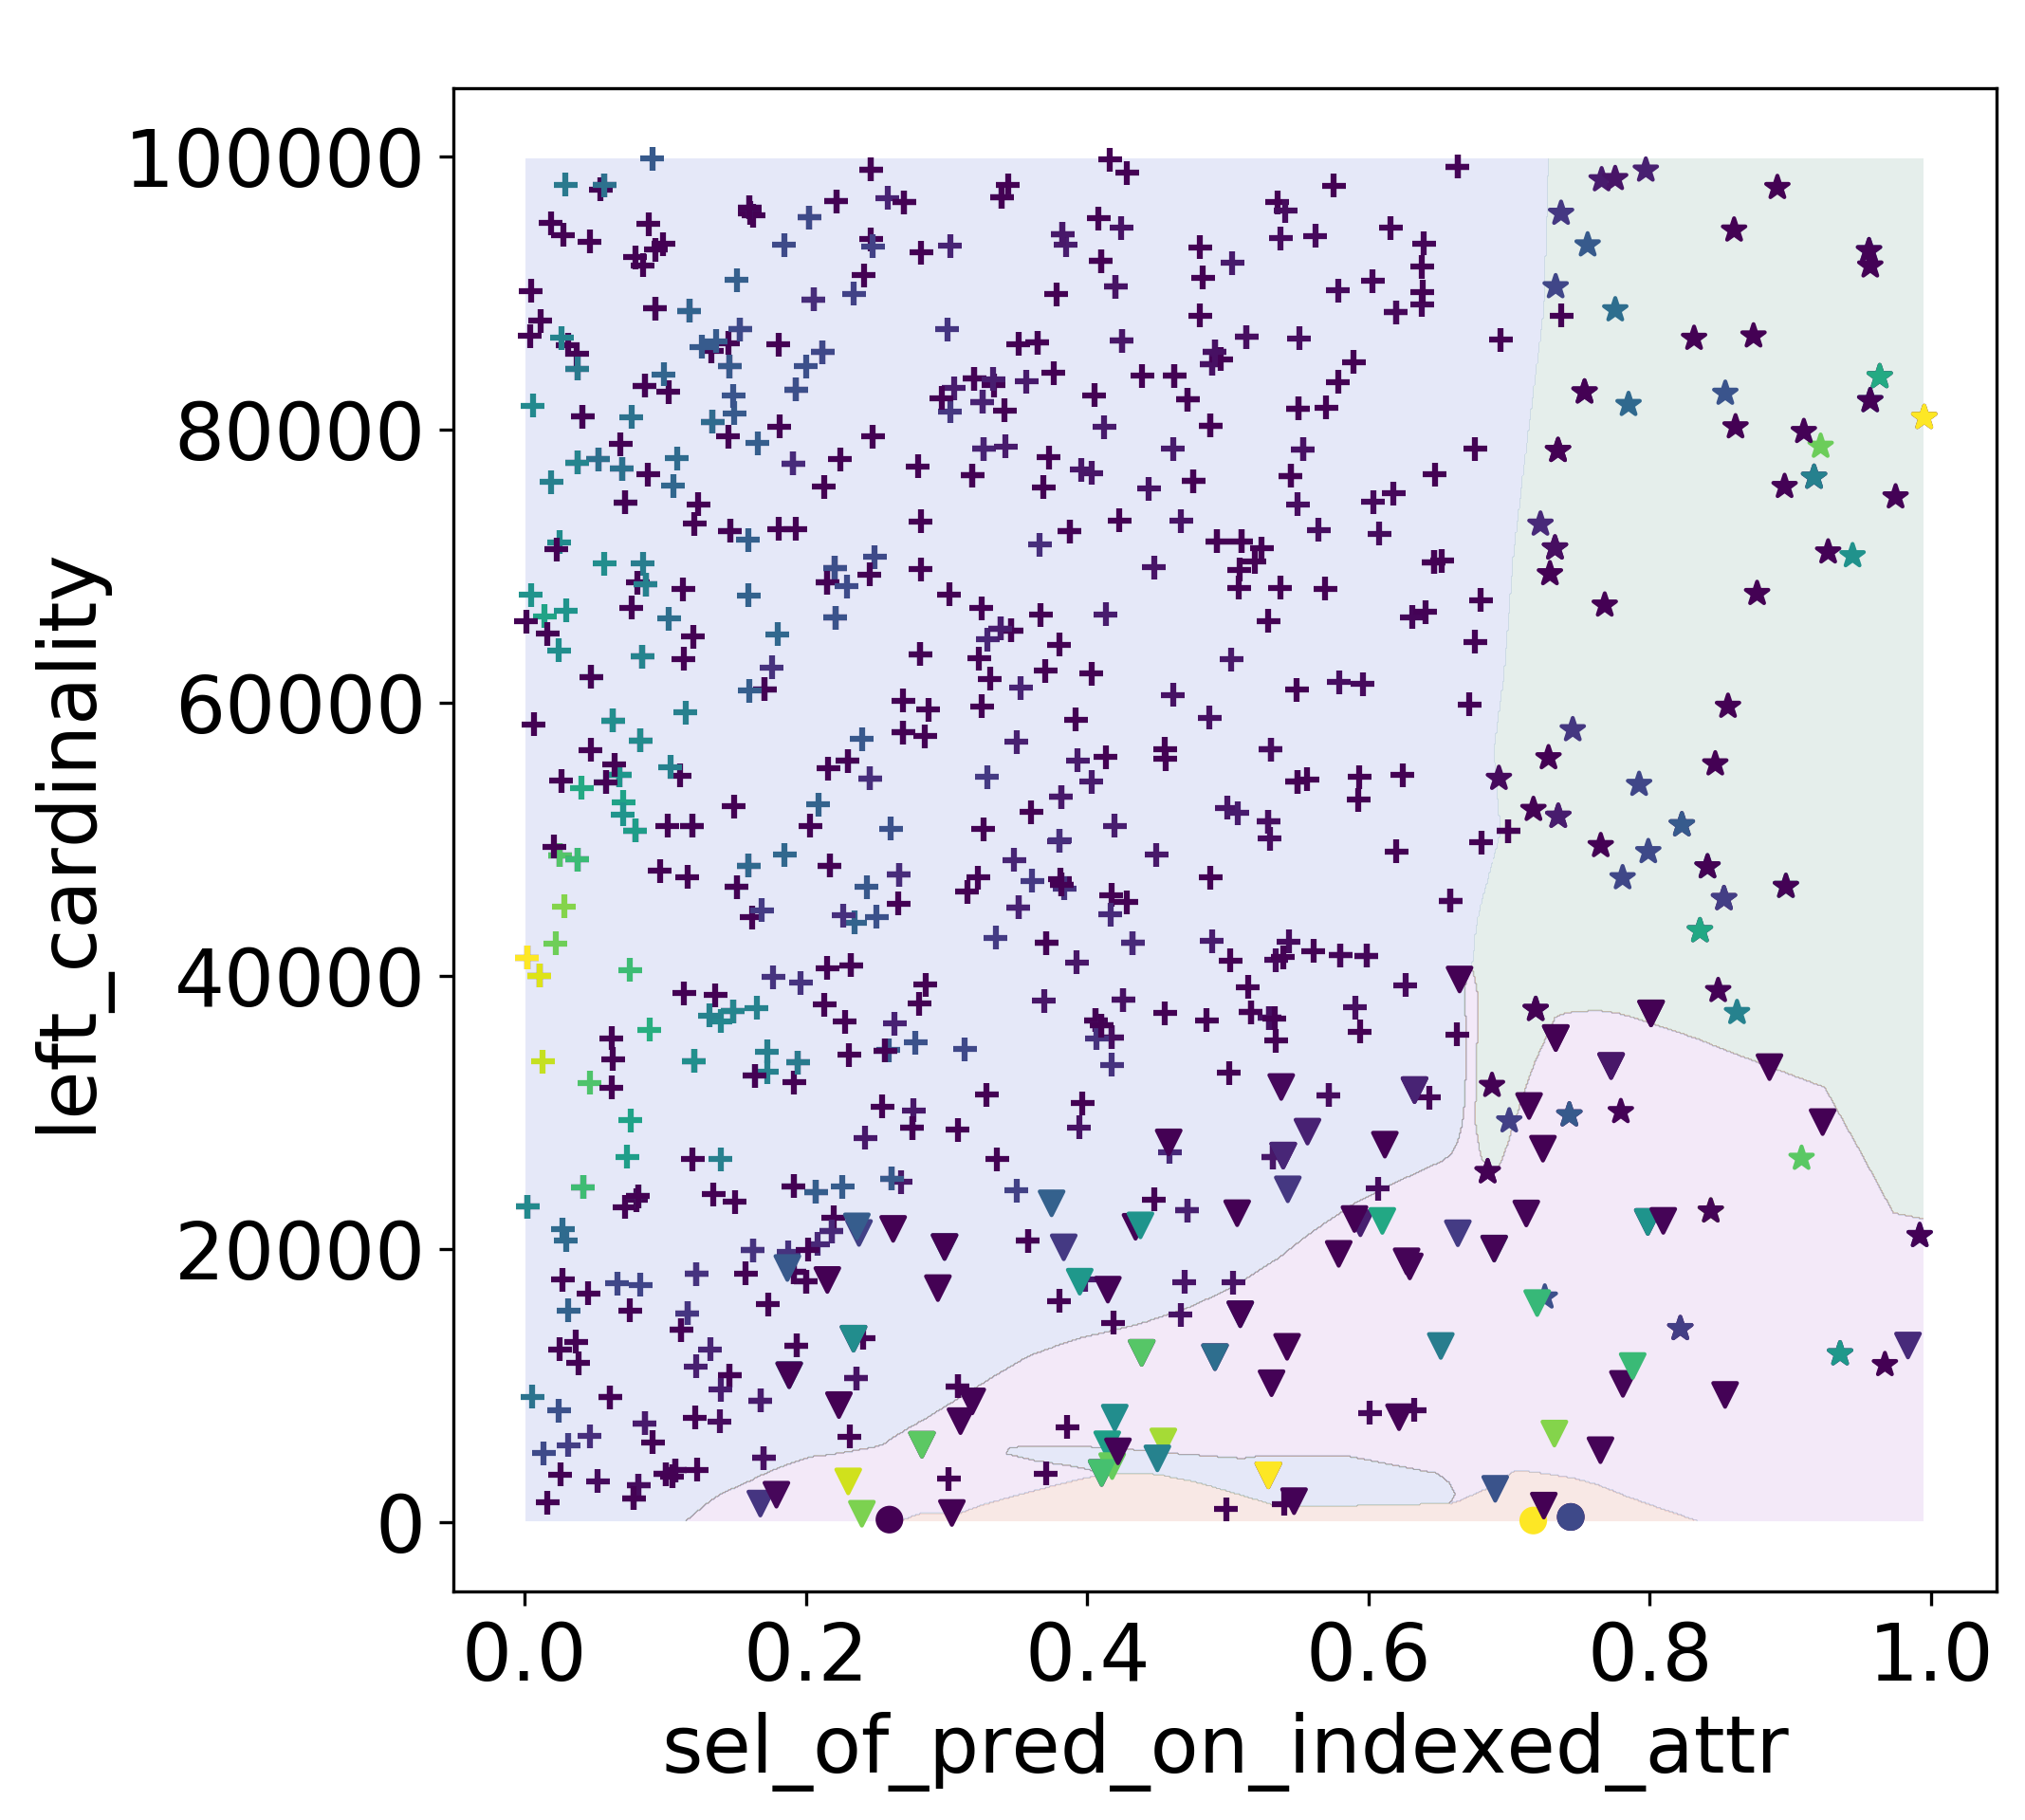

In [29]:
present_idxs = [0]
for i in present_idxs: 
    ds = one_file_dss[i]
    ds_name = one_file_names[i]
    
    # =========================
    X = ds[features]
    y = ds['optimal_decision']
    X_costs = ds[dl.regression_targets]

    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
    X_train_costs, X_test_costs, _, _, = train_test_split(X_costs, y, train_size=0.8, random_state=1)
    X_train, X_test, y_train, y_test = \
        X_train.to_numpy(),X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

    X_train_weights = calculate_importance_from_costs(X_train_costs.to_numpy())

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    X_test = scaler.transform(X_test)

    X_train_weights = preprocessing.MinMaxScaler().fit_transform(X_train_weights.reshape(-1,1)).flatten()
    # =========================
    
    accs = []
    for idx, model_name in enumerate(weighted_clf_model_name_list):
        model = weighted_clf_model_list[model_name.split('(')[0]]        
        if 'DT' in model_name or 'RF' in model_name:
            max_depth = model_name.split('(')[-1].split(')')[0]
            if max_depth.lower() == 'u':
                max_depth = None
            else:
                max_depth = int(max_depth)
            clf = model().fit(X_train, y_train, sample_weight=None, max_depth=max_depth)
        else:
            clf = model().fit(X_train, y_train, sample_weight=None, max_iter=200, weight_decay=0.00001)
            
        print(f"Accuray of {model}: {clf.score(X_test, y_test)}")
        
        # =================================
        # Average misprediction cost
        test_predictions = clf.predict(X_test)
        error_costs = []
        X_test_costs = X_test_costs.to_numpy()
        # print(test_predictions)
        for test_id in range(len(test_predictions)):
            if test_predictions[test_id] != y_test[test_id]:
                error_costs.append(X_test_costs[test_id, test_predictions[test_id]] - X_test_costs[test_id, y_test[test_id]])
        print(f"Misprediction Costs: \nmin: {np.min(error_costs)}; max: {np.max(error_costs)}; median:{np.median(error_costs)}; avg: {np.average(error_costs)}")
        # =================================
        
        if len(features) == 2:
            x_label = features[0] 
            y_label = features[-1]
            if i == 0 and engine=='postgres':
                y_label = 'left_cardinality'
            else:
                y_label = None
            if i == 1 and engine == 'mssql':
                colorbar = False
            else:
                colorbar = False
            plot_2d_decision_boundaries(clf, scaler.inverse_transform(X_train[0:800, :]), X_train_costs.to_numpy()[0:800, :], y_train[0:800], title=f' ', 
                                        x_label=x_label, y_label=y_label, scaler=scaler, 
                                        filename=f'./figures/exp2-viz-wo-sample-weight', plot_colorbar=colorbar)
        
        model_accs[model_name].append(clf.score(X_test, y_test))

    